<a href="https://colab.research.google.com/github/cselmo/ECI23-3D/blob/main/Ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 3: Optimización con FLAME

El objetivo de este ejercicio es experimentar con un código simple de optimización mediante el cual se puede hacer reconstrucción utilizando el modelo FLAME.

Para ello:

1. Correr la sección Setup (abajo) para bajar el códigoo que permite utilizar FLAME (PyTorch).

2. Bajar FLAME 2020: https://flame.is.tue.mpg.de/

*Downloads -> Models -> 'FLAME 2020 (fixed mouth, improved expressions, more data)'*

3. Subir ```generic_model.pkl``` en ```/content/FLAME/model```.

Notas sobre el código:
- Utiliza la librería PyTorch (https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html), y los vectores/matrices se representan a partir de la clase ```Tensor```. Esto permite calcular las derivadas de la función de costo de manera automática.
- La optimización consiste en dos etapas: en la primera etapa se optimizan los parámetros de pose y cámara, y en la segunda etapa se optimizan además los parametros de identidad y expresión de FLAME.
- El modelo de cámara es weak perspective (ortogonal escalado).


## Ejercicio:

- Escribir la función de costo: data term y regularización.

- Modificar los parámetros (learning rate, cantidad de iteraciones, peso de los términos en la función de costo, etc) para mejorar el resultado


## Preguntas:

1. ¿Cual es la función de costo? ¿Qué tipo de regularización se utiliza?

**La función de costo es el error cuadrático medio entre el ground truth de los landmarks y las predicciones realizadas por el modelos.**  
**Se utilizó regularización L2 sólo para los coeficientes de identidad y expresión**
2. ¿Qué ocurre si el learning rate es muy alto / muy bajo?
**Si el learning rate es muy alto, el entrenamiento no converge. Si el learning rate es muy alto, tarda mucho en converger.**
3. ¿Qué ocurre si no se utiliza regularización? (poner peso 0 para la regularización de parámetros de identidad y de expresión). ¿Qué ocurre si la regularización es muy alta?

**Si no regularizamos, los coeficientes de expresión e identidad se hacen muy grandes. Si bien los landmarks aparecen ubicados muy cercanos al ground truth cuando los ploteamos sobre la imagen original, cuando visualizamos el mesh se obtiene una horripilancia absoluta. Si la regularización es muy alta el entrenamiento converge a la cara media.** (ver ejemplos más abajo)

4. ¿Por qué se utilizan dos etapas? Qué pasa si se optimizan todos los parámetros directamente?

**En un principio iba a responder que no se puede entrenar el modelo directamente, pero después de varias pruebas tuve un entrenamiento satisfactorio, solo que tarda mucho más y los coeficientes de expresión e identidad primero crecen mucho mientras que el lmk_loss no baja significativamente y luego converge todo. En definitiva, diría que el entrenamiento se hace mucho más inestable.**

En todos los casos, visualizar con ejemplos concretos.


Nota: hay varias imágenes para probar (ver drive).

# NOTA: Se dejaron los parámetros que funcionaron correctamente en el código.

## Setup

In [1]:
!git clone https://github.com/vabrevaya/FLAME

Cloning into 'FLAME'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 23 (delta 10), reused 18 (delta 5), pack-reused 0
Receiving objects: 100% (23/23), 22.64 KiB | 22.64 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
!pip install chumpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58264 sha256=d014d5af835e193d712dc7c8221e144cd2119355460b1b6f829b09d222a93ffd
  Stored in directory: /root/.cache/pip/wheels/e0/c1/ef/29ba7be03653a29ef6f2c3e1956d6c4d8877f2b243af411db1
Successfully built chumpy


In [3]:
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.3/686.3 kB 10.0 MB/s eta 0:00:00


In [4]:
# bajar imágenes
import gdown
gdown.download("https://drive.google.com/uc?id=1pV8bRp4i277zLzSZ8LutMHWnISYRKkC6", "FFHQ.zip", quiet=False)
! unzip -d data FFHQ.zip

Downloading...
From: https://drive.google.com/uc?id=1pV8bRp4i277zLzSZ8LutMHWnISYRKkC6
To: /content/FFHQ.zip
100%|██████████| 1.22M/1.22M [00:00<00:00, 84.3MB/s]

Archive:  FFHQ.zip
  inflating: data/FFHQ/00000.npy     
  inflating: data/FFHQ/00000.png     
  inflating: data/FFHQ/00001.npy     
  inflating: data/FFHQ/00001.png     
  inflating: data/FFHQ/00002.npy     
  inflating: data/FFHQ/00002.png     
  inflating: data/FFHQ/00003.npy     
  inflating: data/FFHQ/00003.png     
  inflating: data/FFHQ/00004.npy     
  inflating: data/FFHQ/00004.png     
  inflating: data/FFHQ/00005.npy     
  inflating: data/FFHQ/00005.png     
  inflating: data/FFHQ/00006.npy     
  inflating: data/FFHQ/00006.png     
  inflating: data/FFHQ/00007.npy     
  inflating: data/FFHQ/00007.png     
  inflating: data/FFHQ/00008.npy     
  inflating: data/FFHQ/00008.png     
  inflating: data/FFHQ/00009.npy     
  inflating: data/FFHQ/00009.png     


In [5]:
from FLAME.model import FLAME
from FLAME.util import dict2obj, crop
import torch
import torch.nn as nn

import cv2
import numpy as np

## Funciones Auxiliares

In [49]:
def load_image(imgpath):
  img = cv2.imread(imgpath)
  img = img[:, :, [2, 1, 0]]
  img = img.astype(np.float32) / 255.
  return img

def project(X, camera):
    """
      X :     vertices a projectar (torch.Tensor size Nx3)
      camera: torch.Tensor de tamaño 3. La primera componente es la escala,
              las últimas dos representación la traslación en la imágen.
    """
    camera = camera.clone().view(-1, 1, 3)
    # translate
    X_trans = X[:, :, :2] + camera[:, :, 1:]
    # scale (torch.mul so that it works on batches)
    Xn = torch.mul(camera[:, :, 0:1], X_trans)
    Xn[..., 1:] = -Xn[..., 1:]

    return Xn

# funciones de costo
def keypoint_loss(predicted, gt):
  loss = nn.MSELoss()
  return loss(predicted, gt)

def regularizacion(values):
  return values.pow(2.0).sum()

## Optimización

In [71]:
# dimensiones
d_pose = 6
d_cam = 3
d_shape = 100
d_exp = 100

# cpu o gpu
# device = 'cuda'
device = 'cuda'

In [72]:
# crear FLAME (no olvidar subir generic_model.pkl)
cfg = {
    'flame_model_path':'/content/FLAME/model/generic_model.pkl',
    'n_shape':d_shape,
    'n_exp':d_exp,
    'flame_lmk_embedding_path':'/content/FLAME/model/landmark_embedding.npy'
}

cfg=dict2obj(cfg)
flame = FLAME(cfg).to(device)

In [148]:
# cargar imágen (sólo para visualizar)
img = load_image('/content/data/FFHQ/00001.png')

# cargar keypoints correspondientes
gt_kpts = np.load('/content/data/FFHQ/00001.npy').astype(np.float32)

img, gt_kpts = crop(img, gt_kpts)
gt_kpts =  torch.Tensor(gt_kpts).unsqueeze(0).to(device)
gt_kpts = gt_kpts[...,:2]

In [173]:
# === ETAPA 1 ===
# Inicializar parámetros a optimizar: cara media con pose neutra

shape = torch.zeros(1, d_shape).float().to(device)
exp = torch.zeros(1, d_exp).float().to(device)
pose = torch.zeros(1, d_pose).float().to(device)
camera = torch.zeros(1,d_cam)
camera[0] = 5.
camera = camera.float().to(device)

# Para que pytorch tome las variables como optimizables
#shape = nn.Parameter(shape).to(device)
#exp = nn.Parameter(exp).to(device)
camera = nn.Parameter(camera).to(device)
pose = nn.Parameter(pose).to(device)

# Lista de parámetros a optimizar
# params = [shape, exp, pose, camera]
params = [pose, camera]

# Optimizador
# Otra opción : torch.optim.SGD (stochastic gradient descent)
opt = torch.optim.Adam(
    params,
    lr=0.1
)

# === Loop de optimización ===
its_etapa1 = 1000
wid_etapa1 = 0.001
wexp_etapa1 = 0.001

from tqdm import tqdm

with tqdm(range(its_etapa1), unit="iteration") as t_it:
  for it in t_it:
    t_it.set_description("Iteración: ")

    # generar instancia
    vs, pred_kpts, _exit_code = flame(shape, exp, pose)

    # proyectar keypoints
    pred_kpts = project(pred_kpts, camera)
    pred_kpts = pred_kpts[:,:,:2]

    # sólo usamos keypoints estáticos
    pred = pred_kpts[:, 17:, :2]
    gt = gt_kpts[:, 17:, :2]

    # función de costo
    lmk_loss = keypoint_loss(pred_kpts, gt_kpts)
    reg_id = regularizacion(shape)
    reg_exp = regularizacion(exp)

    loss = lmk_loss + wid_etapa1*reg_id + wexp_etapa1*reg_exp

    # optimizar
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()

    # ver progreso
    # print ("iter: %d" % it, "L2 loss: %.4f" % loss)
    t_it.set_postfix(loss=loss.item(), lmk_loss=lmk_loss.item(), reg_id=reg_id.item(), reg_exp=reg_exp.item())

Iteración: : 100%|██████████| 1000/1000 [00:11<00:00, 87.27iteration/s, lmk_loss=0.28, loss=0.28, reg_exp=0, reg_id=0]


In [174]:
# === ETAPA 2 ===

# Agregar shape y expresión
shape = nn.Parameter(shape).to(device)
exp = nn.Parameter(exp).to(device)

# Lista de parámetros a optimizar
params = [shape, exp, pose, camera]

# Crear optimizador de vuelta
opt = torch.optim.Adam(
    params,
    lr=0.1
)

# === Loop de optimización ===
its_etapa2 = 5000
wid_etapa2 = 0.00001
wexp_etapa2 = 0.00001

from tqdm import tqdm

with tqdm(range(its_etapa2), unit="iteration") as t_it:
  for it in t_it:
    t_it.set_description("Iteración: ")

    # generar instancia
    vs, pred_kpts, _ = flame(shape, exp, pose)

    # proyectar landmarks
    pred_kpts = project(pred_kpts, camera)
    pred_kpts = pred_kpts[:,:,:2]

    # sólo usamos landmarks estáticas
    pred = pred_kpts[:, 17:, :2]
    gt = gt_kpts[:, 17:, :2]

    # función de costo
    lmk_loss = keypoint_loss(pred_kpts, gt_kpts)
    reg_id = regularizacion(shape)
    reg_exp = regularizacion(exp)

    loss = lmk_loss + wid_etapa2*reg_id + wexp_etapa2*reg_exp

    # optimizar
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()

    # ver progreso
    t_it.set_postfix(loss=loss.item(), lmk_loss=lmk_loss.item(), reg_id=reg_id.item(), reg_exp=reg_exp.item())

Iteración: : 100%|██████████| 5000/5000 [00:55<00:00, 89.83iteration/s, lmk_loss=0.000828, loss=0.00143, reg_exp=39.2, reg_id=21.4]


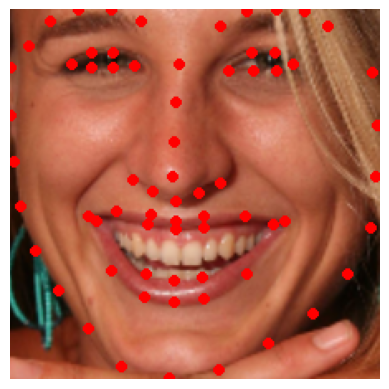

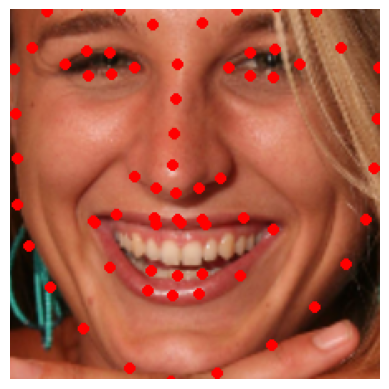

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

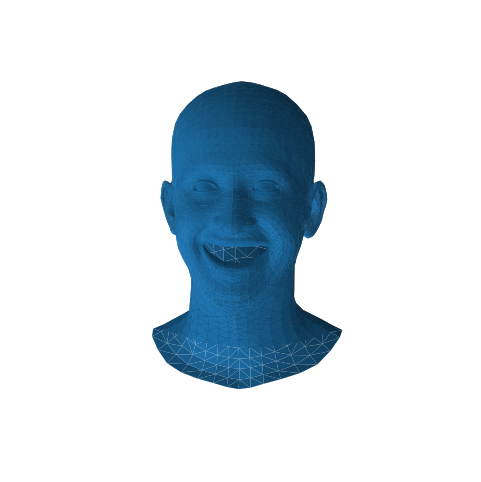

In [175]:
# === Visualización del resultado ===
from matplotlib import pyplot as plt
import trimesh
from FLAME.util import cv2_plot_annotations

# imagen con keypoints
def plot(img, kpt):
  k = kpt.detach().cpu().numpy()
  k  = (k+1) / 2
  k[..., 0] *= img.shape[1]
  k[..., 1] *= img.shape[0]

  img2 = cv2_plot_annotations(img, k, point_rad=2)
  plt.imshow(img2)
  plt.axis("off")
  plt.show()

def render(mesh, title =""):
    fig = plt.figure(figsize=[6,6])
    vertices = mesh.vertices
    faces = mesh.faces
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.view_init(elev=90, azim=-90, roll=0)
    ax.plot_trisurf(
        vertices[:, 0],
        vertices[:,1],
        Z = vertices[:,2],
        triangles=faces)
    ax.grid(False)
    ax.set_title(title)
    ax.set_aspect('equal')
    plt.axis('off')
    plt.show()

plot(img, gt_kpts)
plot(img, pred_kpts)



# guardar mesh
V,_,_ = flame(shape, exp, pose)
V = V[0].detach().cpu().numpy()
F = flame.faces_tensor.cpu().numpy()
mesh = trimesh.Trimesh(vertices=V, faces=F)
mesh.export('result.obj')
from google.colab import files
files.download('result.obj')
render(mesh)

# Ejemplos

1- Reconstrucción sin regularización

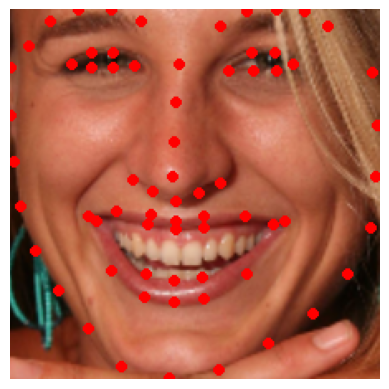

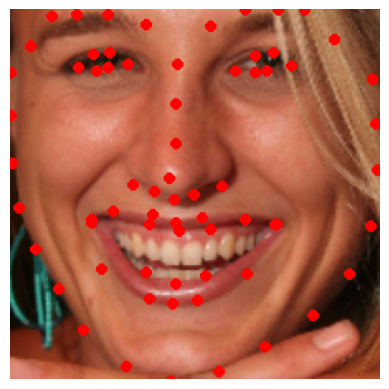

In [100]:
plot(img, gt_kpts)
plot(img, pred_kpts)

Como se ve, los keypoints se recuperan satisfactoriamente. Sin embargo, al renderizar el mesh, se obtiene una cara que no tiene nada que ver con la original:

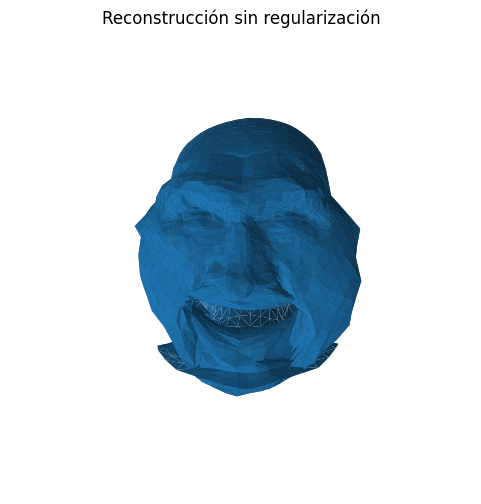

In [102]:
render(mesh,'Reconstrucción sin regularización')

Para esta otra imagen, también se obtienen keypoints ubicados correctamente:

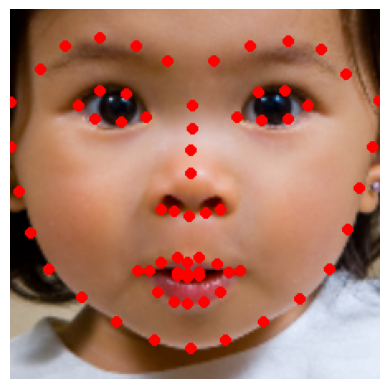

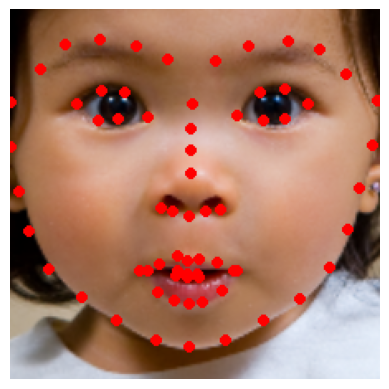

In [111]:
plot(img, gt_kpts)
plot(img, pred_kpts)

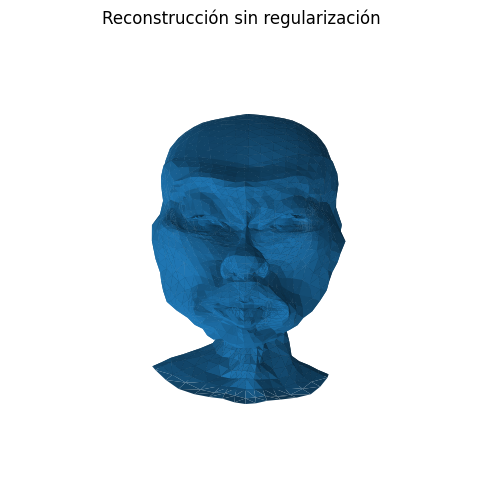

In [112]:
render(mesh,'Reconstrucción sin regularización')

2- Reconstrucción con un nivel apropiado de regularización (0.00001)

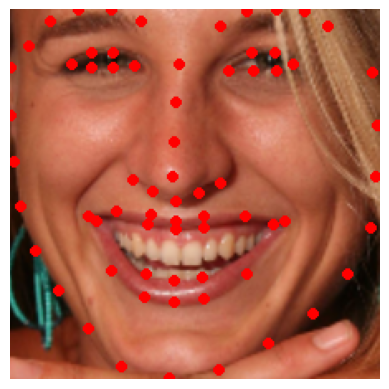

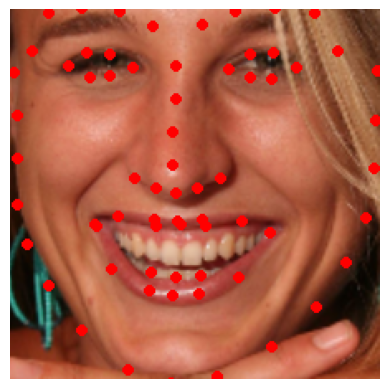

In [118]:
plot(img, gt_kpts)
plot(img, pred_kpts)

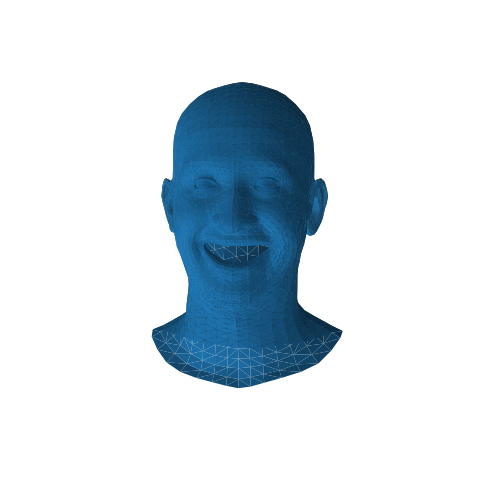

In [119]:
render(mesh)

Otro caso de reconstrucción satisfactoria. Para este caso funcionó mejor bajar un décimo más el término de regularización:

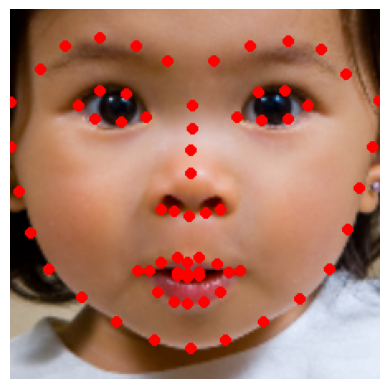

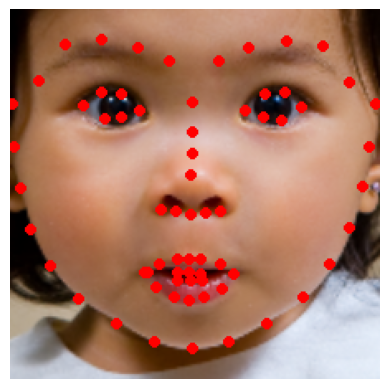

In [134]:
plot(img, gt_kpts)
plot(img, pred_kpts)

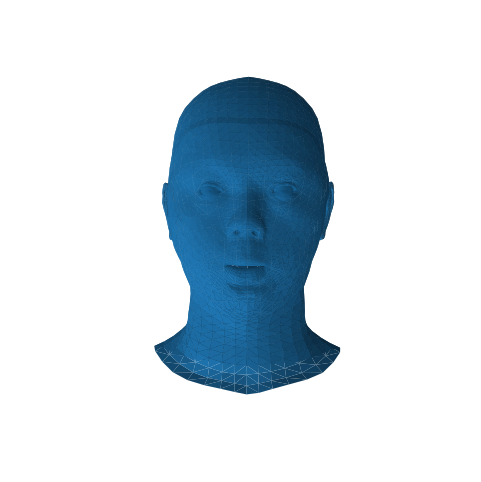

In [135]:
render(mesh)

3- Reconstrucción con regularización muy alta (reg=10.).

En este caso se obtiene siempre la cara media. Cabe aclarar que al estar regularizando solamente expresión e identidad, la ubicación de la camara y la pose se recuperan satisfactoriamente.

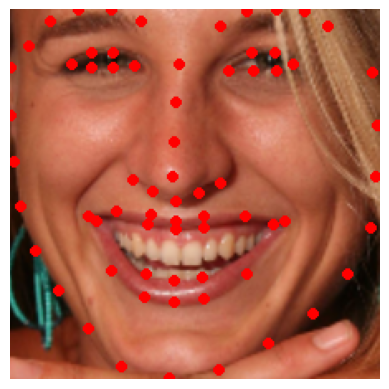

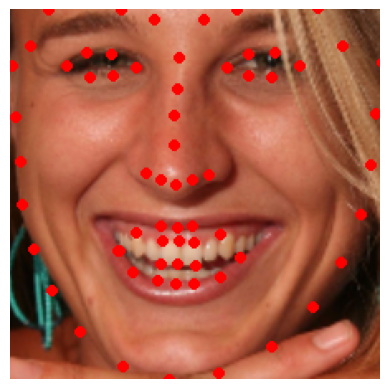

In [140]:
plot(img, gt_kpts)
plot(img, pred_kpts)

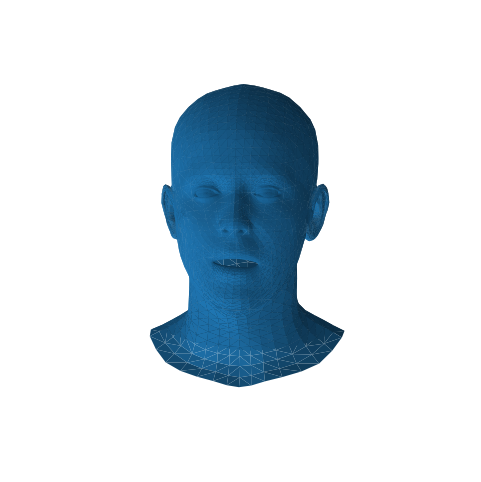

In [141]:
render(mesh)

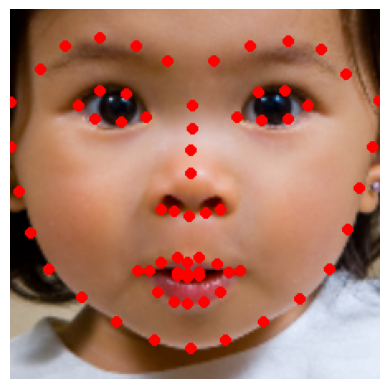

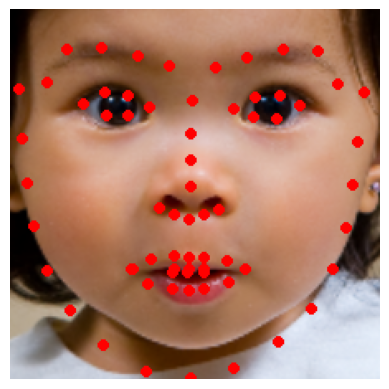

In [146]:
plot(img, gt_kpts)
plot(img, pred_kpts)

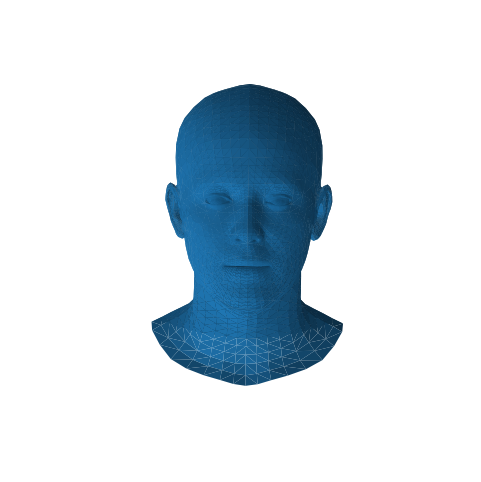

In [147]:
render(mesh)

4- Entrenamiento con learning rate muy grande (lr=10.):

El entrenamiento diverge completamente y se reconstruye ruido.

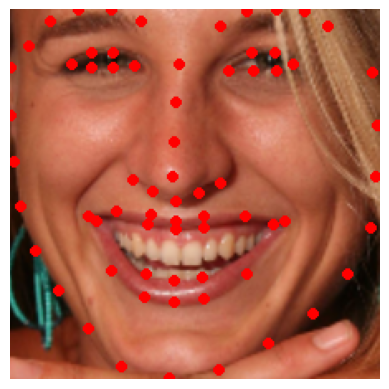

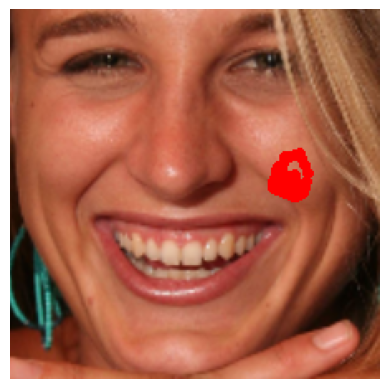

In [167]:
plot(img, gt_kpts)
plot(img, pred_kpts)

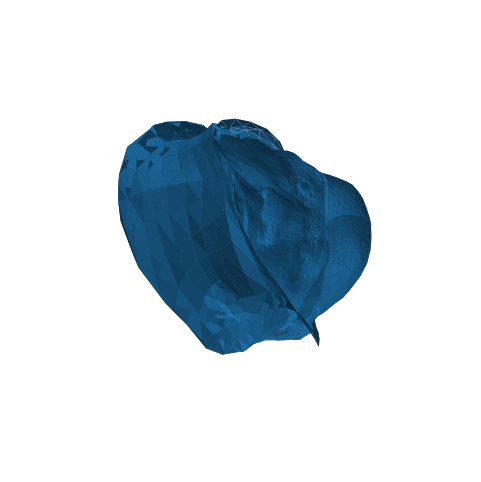

In [168]:
render(mesh)

5- Entrenamiento con learning rate muy chico (lr=1e-16):

Los coeficientes se mantienen en cero y se recupera la cara promedio:

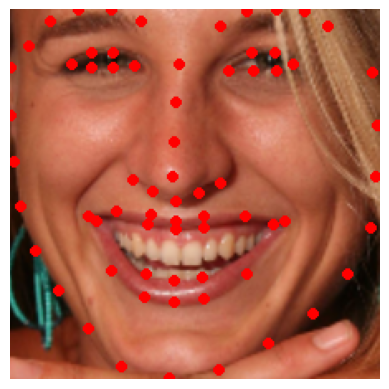

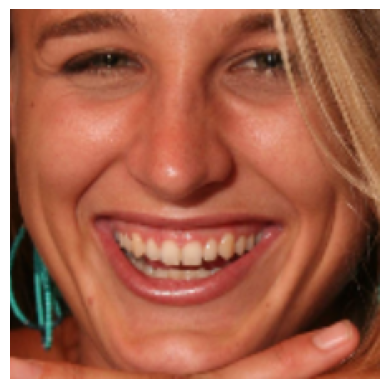

In [162]:
plot(img, gt_kpts)
plot(img, pred_kpts)

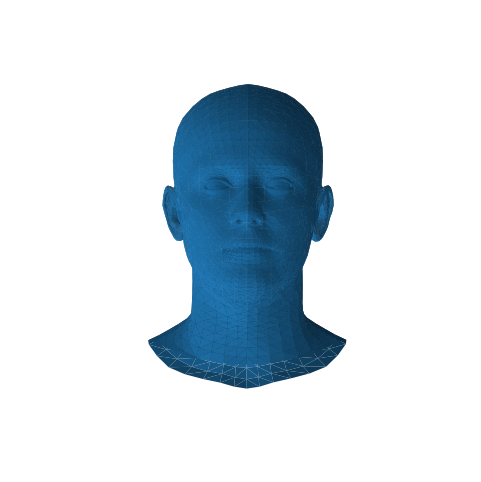

In [163]:
render(mesh)

6- Entrenando todos los coeficientes.

Para hacer converger esto tuve que entrenar con RMSProp y correrlo durante muchas más iteraciones. También hacer varios intentos. El entrenamiento es muy inestable.